Epoch [10/200], Loss: 0.8060
Epoch [20/200], Loss: 0.7905
Epoch [30/200], Loss: 0.7775
Epoch [40/200], Loss: 0.7760
Epoch [50/200], Loss: 0.7747
Epoch [60/200], Loss: 0.7596
Epoch [70/200], Loss: 0.7658
Epoch [80/200], Loss: 0.7588
Epoch [90/200], Loss: 0.7557
Epoch [100/200], Loss: 0.7536
Epoch [110/200], Loss: 0.7519
Epoch [120/200], Loss: 0.7473
Epoch [130/200], Loss: 0.7438
Epoch [140/200], Loss: 0.7437
Epoch [150/200], Loss: 0.7437
Epoch [160/200], Loss: 0.7425
Epoch [170/200], Loss: 0.7338
Epoch [180/200], Loss: 0.7403
Epoch [190/200], Loss: 0.7343
Epoch [200/200], Loss: 0.7300
Test Loss: 0.7323


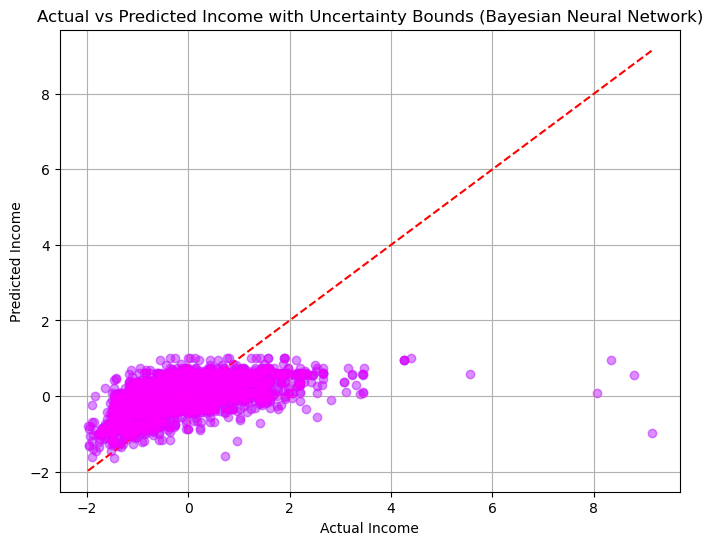

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("ML_salaries.csv")

# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']):
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

# Scale numerical variables
scaler = StandardScaler()
df[df.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(df.select_dtypes(include=['float64', 'int64']))

# Define X and y
X = df.drop(columns=["salary_in_usd", "salary"])
y = df["salary_in_usd"]

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2)

class BayesianDropoutNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_prob):
        super(BayesianDropoutNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

        # Dropout layer for Bayesian approximation
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Instantiate the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size1 = 512
hidden_size2 = 256
output_size = 1
dropout_prob = 0.5  # Lower dropout probability
model = BayesianDropoutNet(input_size, hidden_size1, hidden_size2, output_size, dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Lower learning rate

# Train the model (BNN version with dropout)
num_epochs = 200  # Increase number of epochs
for epoch in range(num_epochs):
    # Enable dropout during training
    model.train()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
with torch.no_grad():
    # Disable dropout during evaluation
    model.eval()

    # Perform Monte Carlo sampling to estimate predictions and uncertainty
    n_samples = 100
    predictions = torch.zeros(n_samples, len(X_test))
    for i in range(n_samples):
        outputs = model(X_test)
        predictions[i] = outputs.squeeze()

    # Compute mean prediction and standard deviation as uncertainty estimate
    prediction_mean = predictions.mean(dim=0)
    prediction_std = predictions.std(dim=0)
    
    # Compute test loss using mean prediction
    test_loss = criterion(prediction_mean.view(-1, 1), y_test.view(-1, 1))
    print(f'Test Loss: {test_loss.item():.4f}') 

# Plot predictions with uncertainty bounds
plt.figure(figsize=(8, 6))
plt.scatter(y_test.numpy(), prediction_mean.numpy(), color="blue", alpha=0.2)
plt.errorbar(y_test.numpy(), prediction_mean.numpy(), yerr=prediction_std.numpy(), fmt='o', color='magenta', alpha=0.3)  # Add error bars
plt.plot([min(y_test.numpy()), max(y_test.numpy())], [min(y_test.numpy()), max(y_test.numpy())], color='red', linestyle='--')
plt.xlabel('Actual Income')
plt.ylabel('Predicted Income')
plt.title('Actual vs Predicted Income with Uncertainty Bounds (Bayesian Neural Network)')
plt.grid(True)
plt.show()

In [5]:
# Load data
df = pd.read_csv("ML_salaries.csv")

# Define X and y
X = df.drop(columns=["salary_in_usd", "salary"])
X.head()

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,Lead Machine Learning Engineer,EUR,FI,50,FI,L
1,2024,EN,FT,ML Engineer,USD,TR,0,TR,S
2,2024,MI,FT,Data Scientist,CHF,CH,50,CH,L
3,2024,EN,FT,Machine Learning Research Engineer,CAD,CA,50,CA,M
4,2024,SE,FT,Business Intelligence Engineer,USD,US,100,US,M
